# Projet Turnovers

## Import des librairies

In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats
import numpy as np
import scipy.stats as stats
import csv
import itertools

from sklearn import model_selection, preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn import tree, svm, metrics
from os import system
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scikitplot.metrics import plot_cumulative_gain
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore")

## Import de notre dataset 

In [131]:
turnover_df = pd.read_csv("depart_employes.csv" , sep = ';', header = 0)

turnover_df.columns=turnover_df.columns.str.lower()

display(turnover_df.head(10))

,satisfaction,derniere_evaluation,nombre_de_projets,nombre_heures_mensuelles_moyenne,temps_passe_dans_entreprise,accident_du_travail,depart,promotion_5_dernieres_annees,service,niveau_salaire
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


# Exploration des données

## Informations sur nos données

In [132]:
def resumetable(df):
    print("Format de la base : {}".format(df.shape))
    summary = pd.DataFrame(df.dtypes, columns=["dtypes"]).reset_index()
    summary["Name"] = summary["index"]
    summary = summary[["Name", "dtypes"]]
    summary["Missing"] = df.isna().sum().values
    summary["Miss_percent"] = round((summary["Missing"]*100)/df.shape[0],0)
    summary["Uniques"] = df.nunique().values
    summary["First value"] = df.iloc[0].values
    summary["Second value"] = df.iloc[1].values
    summary["Third value"] = df.iloc[2].values

    return display(summary)

print("Statistiques macro sur la table de turnover :")
resumetable(turnover_df)

Statistiques macro sur la table de turnover :
Format de la base : (14999, 10)


,Name,dtypes,Missing,Miss_percent,Uniques,First value,Second value,Third value
0,satisfaction,float64,0,0.0,92,0.38,0.8,0.11
1,derniere_evaluation,float64,0,0.0,65,0.53,0.86,0.88
2,nombre_de_projets,int64,0,0.0,6,2,5,7
3,nombre_heures_mensuelles_moyenne,int64,0,0.0,215,157,262,272
4,temps_passe_dans_entreprise,int64,0,0.0,8,3,6,4
5,accident_du_travail,int64,0,0.0,2,0,0,0
6,depart,int64,0,0.0,2,1,1,1
7,promotion_5_dernieres_annees,int64,0,0.0,2,0,0,0
8,service,object,0,0.0,10,sales,sales,sales
9,niveau_salaire,object,0,0.0,3,low,medium,medium


In [133]:
display(turnover_df.describe())

,satisfaction,derniere_evaluation,nombre_de_projets,nombre_heures_mensuelles_moyenne,temps_passe_dans_entreprise,accident_du_travail,depart,promotion_5_dernieres_annees
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


## Détection de doublons

In [134]:
turnover_df.duplicated(keep="first").sum()

3008

In [135]:
turnover_df.drop_duplicates(inplace=True)

## Moyenne des variables quantitatives en fonction du départ

In [136]:
columns_quanti=['satisfaction','derniere_evaluation','nombre_de_projets','nombre_heures_mensuelles_moyenne','temps_passe_dans_entreprise','depart']

df_quanti=turnover_df[columns_quanti]
# Calculer la moyenne des variables en fonction de la colonne 'depart'
moyennes = df_quanti.groupby('depart').mean()

display(moyennes)

,satisfaction,derniere_evaluation,nombre_de_projets,nombre_heures_mensuelles_moyenne,temps_passe_dans_entreprise
depart,,,,,
0,0.667365,0.715667,3.786800,198.94270,3.262000
1,0.440271,0.721783,3.883476,208.16223,3.881467


## Graphiques d'exploration des données 

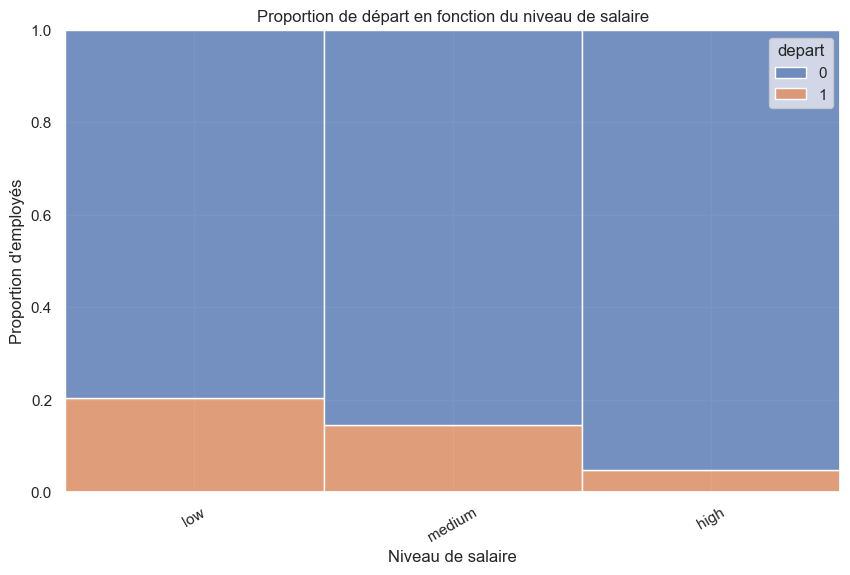

In [137]:
sns.set()
plt.figure(figsize=(10, 6))  # Ajustement de la taille du graphique
sns.histplot(data=turnover_df, x="niveau_salaire", hue="depart", multiple="fill", stat="percent")
plt.xticks(rotation=30) 
plt.title("Proportion de départ en fonction du niveau de salaire")
plt.xlabel("Niveau de salaire") 
plt.ylabel("Proportion d'employés")   
plt.show()

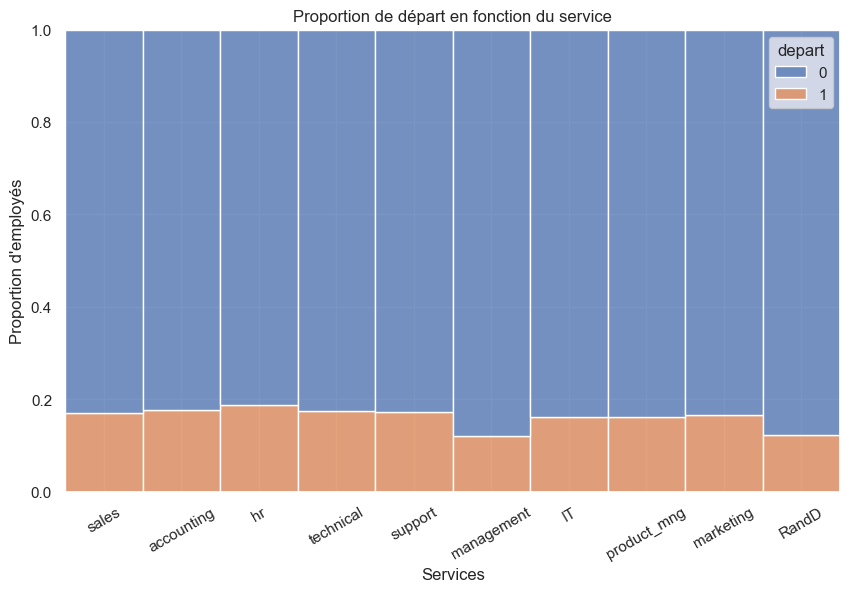

In [138]:
sns.set()

plt.figure(figsize=(10, 6))  # Ajustement de la taille du graphique
sns.histplot(data=turnover_df, x="service", hue="depart", multiple="fill", stat="percent")
plt.xticks(rotation=30) 
plt.title("Proportion de départ en fonction du service")
plt.xlabel("Services") 
plt.ylabel("Proportion d'employés")   
plt.show()

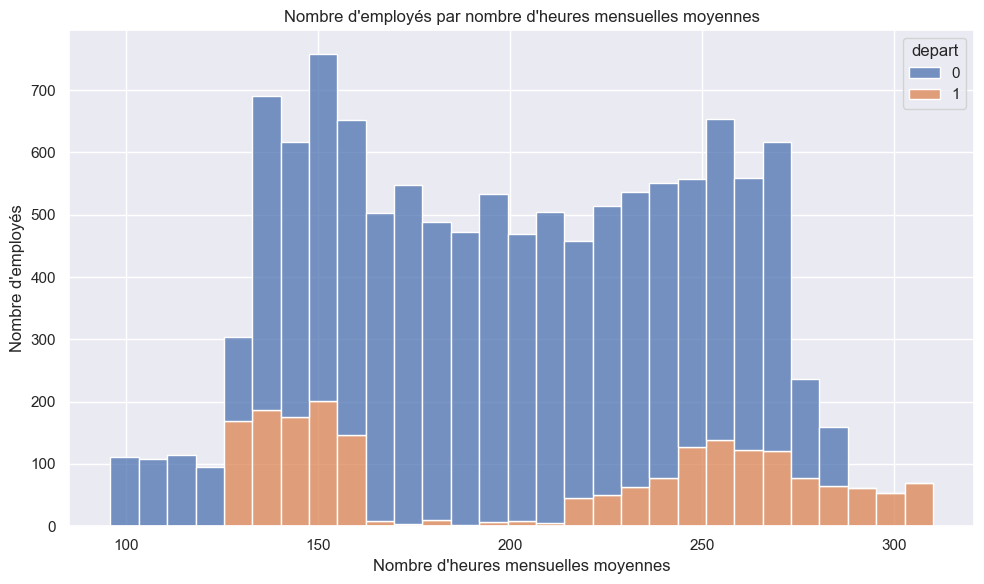

In [139]:
plt.figure(figsize=(10, 6))
sns.histplot(data=turnover_df, x="nombre_heures_mensuelles_moyenne", hue="depart", multiple="stack", kde=False)
plt.title("Nombre d'employés par nombre d'heures mensuelles moyennes")
plt.xlabel("Nombre d'heures mensuelles moyennes") 
plt.ylabel("Nombre d'employés")  
plt.tight_layout()
plt.show()

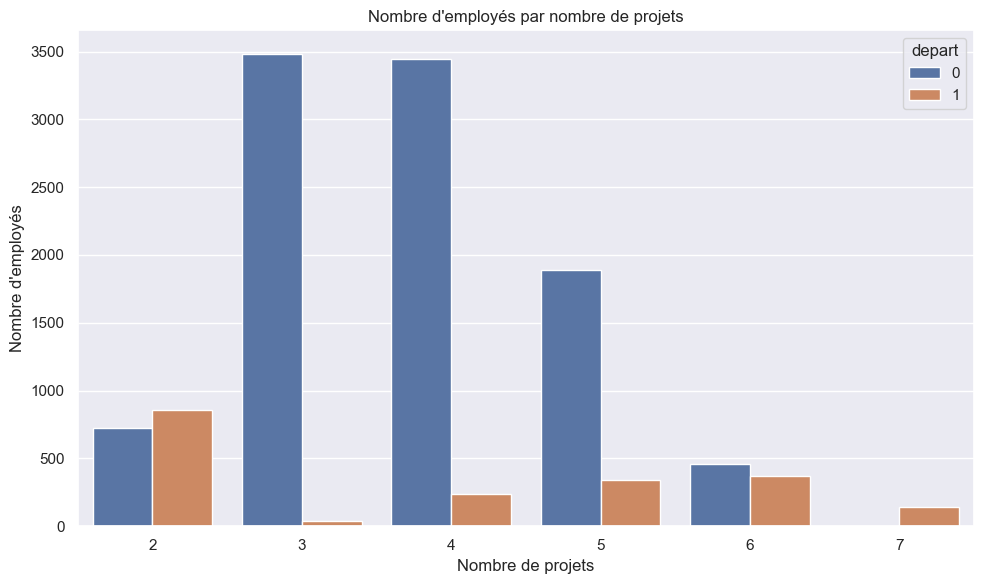

In [140]:
plt.figure(figsize=(10, 6))
sns.countplot(data=turnover_df, x="nombre_de_projets", hue="depart")
plt.title("Nombre d'employés par nombre de projets")
plt.xlabel("Nombre de projets")
plt.ylabel("Nombre d'employés")
plt.tight_layout()
plt.show()

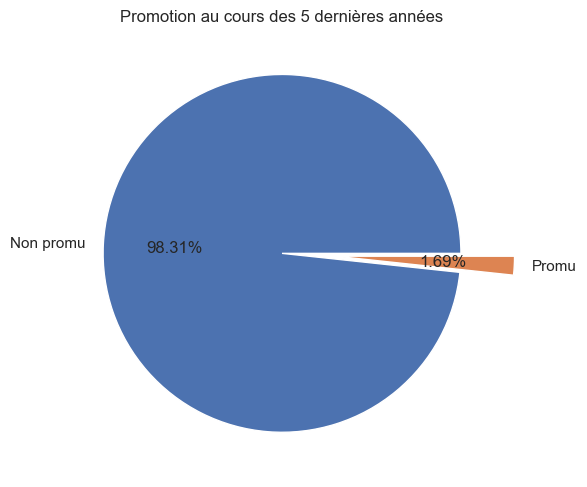

In [141]:
#Graphique circulaire sur la promotion au cours des 5 dernières années
labels = turnover_df["promotion_5_dernieres_annees"].value_counts().index.tolist()
labels = ["Promu" if i == 1 else "Non promu" for i in labels]


plt.figure(figsize=(6, 6))
plt.pie(x = turnover_df["promotion_5_dernieres_annees"].value_counts(), labels=labels, autopct="%1.2f%%", explode=[0, 0.3])
plt.title("Promotion au cours des 5 dernières années")
plt.tight_layout()
plt.show()

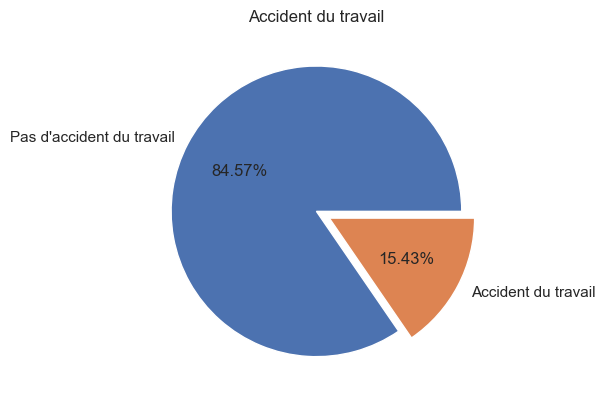

In [142]:
labels = turnover_df["accident_du_travail"].value_counts().index.tolist()
labels = ["Accident du travail" if i == 1 else "Pas d'accident du travail" for i in labels]

plt.figure(figsize=(6, 6))
plt.pie(x = turnover_df["accident_du_travail"].value_counts(), labels=labels, autopct="%1.2f%%", explode=[0, 0.1])
plt.title("Accident du travail")
plt.tight_layout()
plt.show()

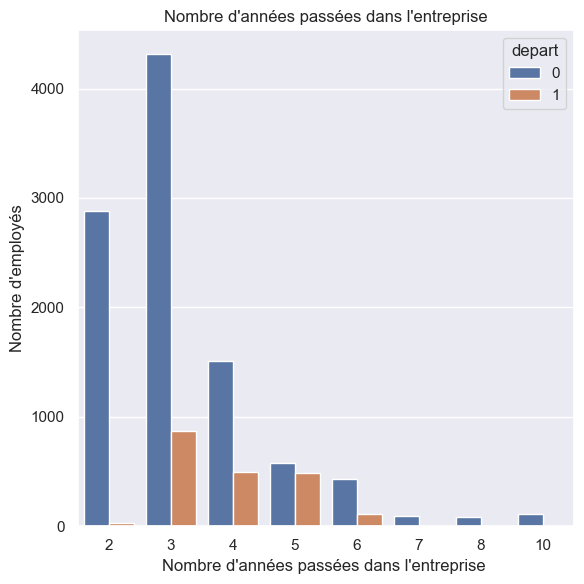

In [143]:
labels = turnover_df["temps_passe_dans_entreprise"].value_counts().index.tolist()

plt.figure(figsize=(6, 6))
sns.countplot(x = "temps_passe_dans_entreprise", data=turnover_df, hue="depart")
plt.title("Nombre d'années passées dans l'entreprise")
plt.xlabel("Nombre d'années passées dans l'entreprise ")  # Ajout de l'étiquette pour l'axe x
plt.ylabel("Nombre d'employés")
plt.tight_layout()
plt.show()

# Pre-processing

## Encodage des données quantitatives avec OrdinalEncoder

In [144]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()

turnover_df['service'] = ord_enc.fit_transform(turnover_df[['service']])
turnover_df['niveau_salaire'] = ord_enc.fit_transform(turnover_df[['niveau_salaire']])

<Axes: >

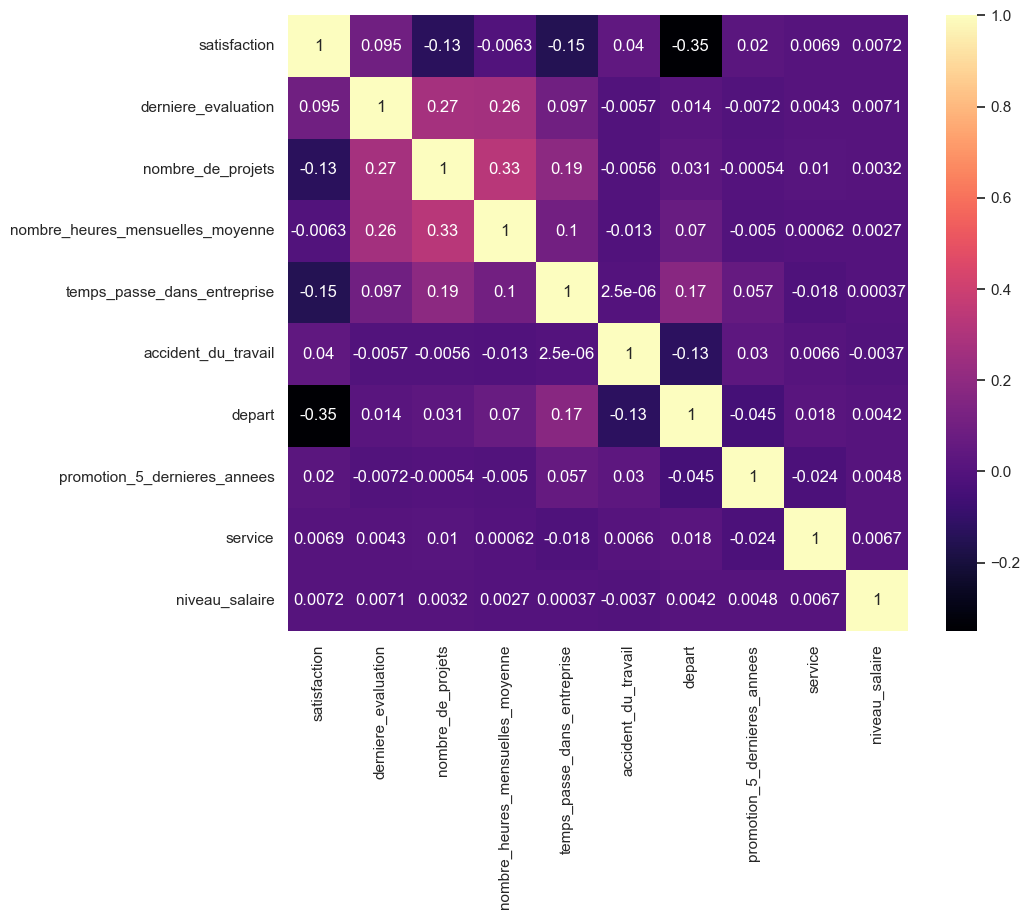

In [145]:
correlation = turnover_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='magma')

In [146]:
data = turnover_df.drop(columns=['depart'])
target = turnover_df['depart']

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [147]:
# Créer un classifieur Decision Tree
clf_tree = DecisionTreeClassifier(random_state=42)

param_grid_tree = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Créer un objet GridSearchCV
grid_search_tree = GridSearchCV(clf_tree, param_grid_tree, cv=5, scoring='accuracy', n_jobs=-1)

# Effectuer la recherche sur grille
grid_search_tree.fit(x_train, y_train)

# Afficher les meilleurs paramètres et la meilleure précision
print("Meilleurs paramètres :", grid_search_tree.best_params_)

# Utiliser les meilleurs paramètres pour créer un nouveau modèle
best_tree = grid_search_tree.best_estimator_
best_tree.fit(x_train, y_train)

# Évaluer la performance du modèle sur les données de test
print("Fiabilité decision tree sur ensemble d'entraînement : %0.3f" % best_tree.score(x_train, y_train))
print("Fiabilité decision tree sur ensemble de test : %0.3f" % best_tree.score(x_test, y_test))

Meilleurs paramètres : {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 20}
Fiabilité decision tree sur ensemble d'entraînement : 0.987
Fiabilité decision tree sur ensemble de test : 0.979


In [148]:
# Initialiser le modèle Random Forest
clf_RF = RandomForestClassifier(random_state=42)

param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialiser la recherche par grille avec une validation croisée à 5 plis
grid_search_RF = GridSearchCV(clf_RF, param_grid_RF, cv=5, scoring='accuracy', n_jobs=-1)

# Exécuter la recherche par grille sur les données d'entraînement
grid_search_RF.fit(x_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres :", grid_search_RF.best_params_)

# Entraîner le modèle avec les meilleurs hyperparamètres sur toutes les données d'entraînement
best_clf_RF = grid_search_RF.best_estimator_
best_clf_RF.fit(x_train, y_train)

# Évaluer la performance du modèle sur les données de test
print("Fiabilité random forest sur ensemble d'entraînement : %0.3f" % best_clf_RF.score(x_train, y_train))
print("Fiabilité random forest sur ensemble de test : %0.3f" % best_clf_RF.score(x_test, y_test))

Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Fiabilité random forest sur ensemble d'entraînement : 0.987
Fiabilité random forest sur ensemble de test : 0.980


In [149]:
clf_log_reg = LogisticRegression(random_state=42)
clf_log_reg.fit(x_train, y_train)

print("Fiabilité logistic regression sur ensemble d'entraînement : %0.3f" % clf_log_reg.score(x_train, y_train))
print("Fiabilité logistic regression sur ensemble de test : %0.3f" % clf_log_reg.score(x_test, y_test))

Fiabilité logistic regression sur ensemble d'entraînement : 0.835
Fiabilité logistic regression sur ensemble de test : 0.834


In [150]:
# Initialiser le modèle KNN
clf_knn = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [2, 5, 10, 20],
}

# Initialiser la recherche par grille avec une validation croisée à 5 plis
grid_search_knn = GridSearchCV(clf_knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)

# Exécuter la recherche par grille sur les données d'entraînement
grid_search_knn.fit(x_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres :", grid_search_knn.best_params_)

# Entraîner le modèle avec les meilleurs hyperparamètres sur toutes les données d'entraînement
best_clf_knn = grid_search_knn.best_estimator_
best_clf_knn.fit(x_train, y_train)

print("Régression logistique sur ensemble d'entraînement : %0.3f" % best_clf_knn.score(x_train, y_train))
print("Regression logistique sur ensemble de test : %0.3f" % best_clf_knn.score(x_test, y_test))

Meilleurs hyperparamètres : {'n_neighbors': 5}
Régression logistique sur ensemble d'entraînement : 0.955
Regression logistique sur ensemble de test : 0.940


In [153]:
clf_SVM = svm.SVC(gamma='scale', kernel='linear')
clf_SVM .fit(x_train, y_train)

print("Fiabilité SVM sur ensemble d'entraînement : %0.3f" % clf_SVM.score(x_train, y_train))
print("Fiabilité SVM sur ensemble de test : %0.3f" % clf_SVM.score(x_test, y_test))

Fiabilité SVM sur ensemble d'entraînement : 0.834
Fiabilité SVM sur ensemble de test : 0.833


In [154]:
from keras.models import Sequential
from keras.layers import Dense

clf_nn = Sequential()
clf_nn.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))  # Couche d'entrée avec 64 neurones
clf_nn.add(Dense(32, activation='relu'))  # Couche cachée avec 32 neurones
clf_nn.add(Dense(1, activation='sigmoid'))  # Couche de sortie binaire
 
# Compilation du modèle
clf_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
# Entraînement du modèle
clf_nn.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, validation_split=0.2)

# Évaluation du modèle sur l'ensemble de test
loss, accuracy = clf_nn.evaluate(x_test, y_test)
print(f'Accuracy: {accuracy:.3f}')

Epoch 1/10
120/120 [==============================] - 1s 2ms/step - loss: 0.7584 - accuracy: 0.8061 - val_loss: 0.5179 - val_accuracy: 0.8249
Epoch 2/10
120/120 [==============================] - 0s 2ms/step - loss: 0.5031 - accuracy: 0.8187 - val_loss: 0.4705 - val_accuracy: 0.8348
Epoch 3/10
120/120 [==============================] - 0s 1ms/step - loss: 0.4637 - accuracy: 0.8306 - val_loss: 0.4228 - val_accuracy: 0.8348
Epoch 4/10
120/120 [==============================] - 0s 2ms/step - loss: 0.4491 - accuracy: 0.8332 - val_loss: 0.4056 - val_accuracy: 0.8348
Epoch 5/10
120/120 [==============================] - 0s 1ms/step - loss: 0.4354 - accuracy: 0.8286 - val_loss: 0.4685 - val_accuracy: 0.8280
Epoch 6/10
120/120 [==============================] - 0s 1ms/step - loss: 0.4128 - accuracy: 0.8284 - val_loss: 0.3937 - val_accuracy: 0.8348
Epoch 7/10
120/120 [==============================] - 0s 1ms/step - loss: 0.3983 - accuracy: 0.8323 - val_loss: 0.3875 - val_accuracy: 0.8343
Epoch 

In [155]:
# Prédire les données issues des différents classifiers
y_pred_tree = best_tree.predict(x_test)
y_pred_RF = best_clf_RF.predict(x_test)
y_pred_log_reg = clf_log_reg.predict(x_test)
y_pred_knn = best_clf_knn.predict(x_test)
y_pred_SVM = clf_SVM.predict(x_test)
y_pred_nn = np.round(clf_nn.predict(x_test).astype(int))

75/75 [==============================] - 0s 833us/step


In [156]:
# Calculer les rapports de classification pour chaque classificateur
classification_report_tree = classification_report(y_test, y_pred_tree, output_dict=True)
classification_report_RF = classification_report(y_test, y_pred_RF, output_dict=True)
classification_report_log_reg = classification_report(y_test, y_pred_log_reg, output_dict=True)
classification_report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
classification_report_SVM = classification_report(y_test, y_pred_SVM, output_dict=True)
classification_report_nn = classification_report(y_test, y_pred_nn, output_dict=True)

accuracy_train_tree = best_tree.score(x_train, y_train)
accuracy_train_RF = best_clf_RF.score(x_train, y_train)
accuracy_train_log_reg = clf_log_reg.score(x_train, y_train)
accuracy_train_knn = best_clf_knn.score(x_train, y_train)
accuracy_train_SVM = clf_SVM.score(x_train, y_train)

# Créer un DataFrame avec les métriques de train accuracy, rappel, précision et f1-score pour chaque classificateur
df_metrics = pd.DataFrame({
    'Decision Tree': classification_report_tree['weighted avg'],
    'Random Forest': classification_report_RF['weighted avg'],
    'Logistic Regression': classification_report_log_reg['weighted avg'],
    'KNN': classification_report_knn['weighted avg'],
    'SVM': classification_report_SVM['weighted avg'],
    'Neural Network': classification_report_nn['weighted avg']
})

# Suppression de la dernière ligne
df_metrics = df_metrics.drop(df_metrics.tail(1).index)

df_metrics.loc['Train Accuracy'] = [accuracy_train_tree, accuracy_train_RF, accuracy_train_log_reg, accuracy_train_knn, accuracy_train_SVM, accuracy]

df_metrics = df_metrics.reindex(['Train Accuracy', 'recall', 'precision', 'f1-score'])

df_metrics = df_metrics.round(3)
display(df_metrics)

,Decision Tree,Random Forest,Logistic Regression,KNN,SVM,Neural Network
Train Accuracy,0.987,0.987,0.835,0.955,0.834,0.830
recall,0.979,0.980,0.834,0.940,0.833,0.833
precision,0.979,0.980,0.797,0.942,0.694,0.694
f1-score,0.978,0.980,0.801,0.941,0.757,0.757


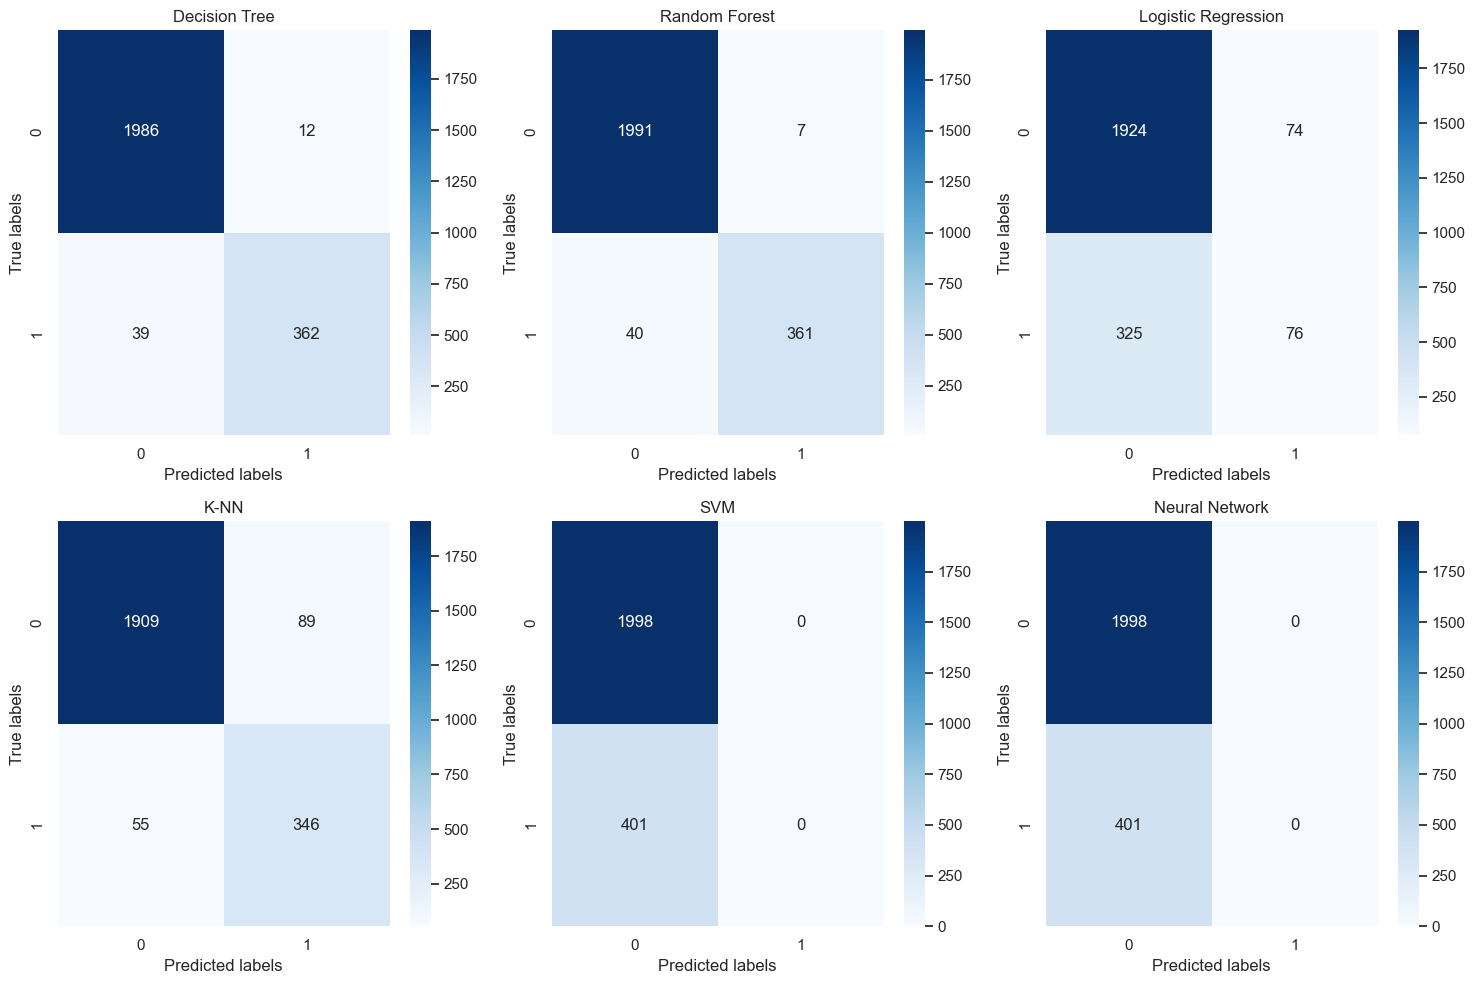

In [157]:
# Créer les matrices de confusion pour les prédictions
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
conf_matrix_RF = confusion_matrix(y_test, y_pred_RF)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
conf_matrix_SVM = confusion_matrix(y_test, y_pred_SVM)
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)

model_names = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'K-NN', 'SVM', "Neural Network"]
conf_matrices = [conf_matrix_tree, conf_matrix_RF, conf_matrix_log_reg, conf_matrix_knn, conf_matrix_SVM, conf_matrix_nn]

# Créer un sous-graphique avec plusieurs axes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Parcourir chaque matrice de confusion et son nom de modèle associé
for ax, conf_matrix, model_name in zip(axes.flatten(), conf_matrices, model_names):
    # Utiliser seaborn pour afficher la matrice de confusion
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_title(model_name)  # Définir le titre du sous-graphique comme le nom du modèle
    ax.set_xlabel('Predicted labels')  # Définir le titre de l'axe x
    ax.set_ylabel('True labels')  # Définir le titre de l'axe y

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

plt.show()

In [158]:
# Prédire les données issues des différents classifiers
y_pred_proba_tree = best_tree.predict_proba(x_test)
y_pred_proba_RF = best_clf_RF.predict_proba(x_test)
y_pred_proba_log_reg = clf_log_reg.predict_proba(x_test)
y_pred_proba_knn = best_clf_knn.predict_proba(x_test)

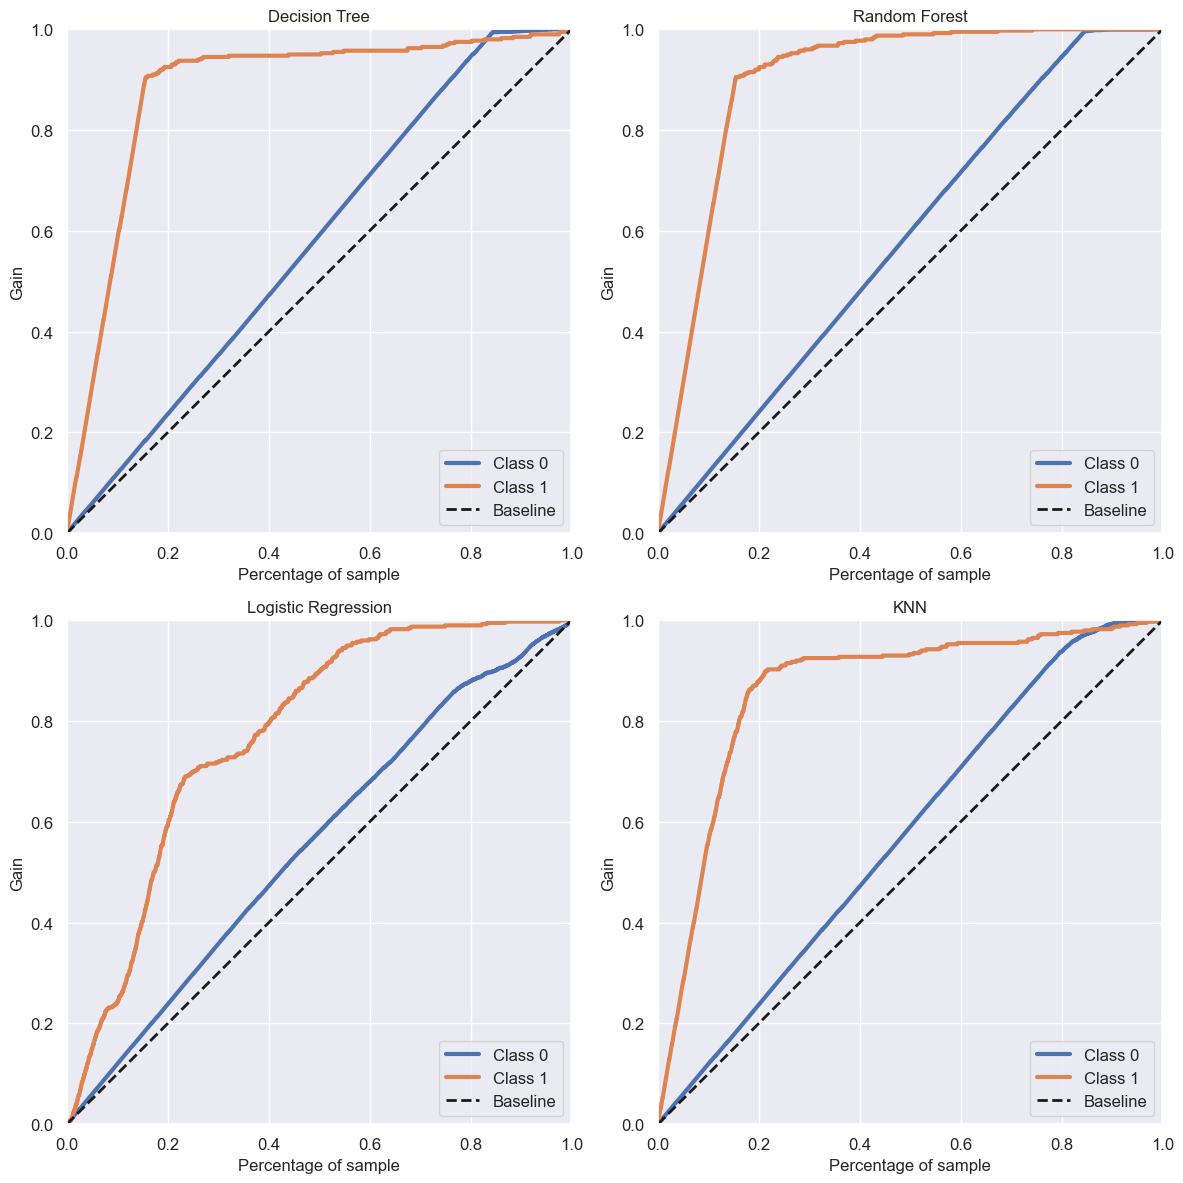

In [159]:
# Créer un sous-graphique avec plusieurs axes
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Tracer et afficher la courbe de gain cumulé pour le Decision Tree
plot_cumulative_gain_tree = plot_cumulative_gain(y_test, y_pred_proba_tree, ax=axes[0, 0])
axes[0, 0].set_title('Decision Tree')

# Tracer et afficher la courbe de gain cumulé pour le Random Forest
plot_cumulative_gain_RF = plot_cumulative_gain(y_test, y_pred_proba_RF, ax=axes[0, 1])
axes[0, 1].set_title('Random Forest')

# Tracer et afficher la courbe de gain cumulé pour la Logistic Regression
plot_cumulative_gain_log_reg = plot_cumulative_gain(y_test, y_pred_proba_log_reg, ax=axes[1, 0])
axes[1, 0].set_title('Logistic Regression')

# Tracer et afficher la courbe de gain cumulé pour le KNN
plot_cumulative_gain_knn = plot_cumulative_gain(y_test, y_pred_proba_knn, ax=axes[1, 1])
axes[1, 1].set_title('KNN')

# Ajuster automatiquement l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()

# Avec Dichotomisation

In [160]:
turnover_df = pd.read_csv("depart_employes.csv" , sep = ';', header = 0)

turnover_df_dum = pd.get_dummies(turnover_df, "Service")
turnover_df_dum = pd.get_dummies(turnover_df_dum, "niveau_salaire")

data_dum = turnover_df_dum.drop(columns=['depart'])
target_dum = turnover_df_dum['depart']

x_train_dum, x_test_dum, y_train_dum, y_test_dum = train_test_split(data_dum, target_dum, test_size=0.2, random_state=42)

clf_tree = DecisionTreeClassifier(random_state=42)
param_grid_tree = {
    'max_depth': [7],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
    'criterion': ['entropy']
}
grid_search_tree = GridSearchCV(clf_tree, param_grid_tree, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(x_train_dum, y_train_dum)
best_tree = grid_search_tree.best_estimator_
best_tree.fit(x_train_dum, y_train_dum)

clf_RF = RandomForestClassifier(random_state=42)
param_grid_RF = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}
grid_search_RF = GridSearchCV(clf_RF, param_grid_RF, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_RF.fit(x_train_dum, y_train_dum)
best_clf_RF = grid_search_RF.best_estimator_
best_clf_RF.fit(x_train_dum, y_train_dum)

clf_knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [2],
}
grid_search_knn = GridSearchCV(clf_knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(x_train_dum, y_train_dum)
best_clf_knn = grid_search_knn.best_estimator_
best_clf_knn.fit(x_train_dum, y_train_dum)

y_pred_tree_dum = best_tree.predict(x_test_dum)
y_pred_RF_dum = best_clf_RF.predict(x_test_dum)
y_pred_knn_dum = best_clf_knn.predict(x_test_dum)

classification_report_tree_dum = classification_report(y_test_dum, y_pred_tree_dum, output_dict=True)
classification_report_RF_dum = classification_report(y_test_dum, y_pred_RF_dum, output_dict=True)
classification_report_knn_dum = classification_report(y_test_dum, y_pred_knn_dum, output_dict=True)

accuracy_train_tree_dum = best_tree.score(x_train_dum, y_train_dum)
accuracy_train_RF_dum = best_clf_RF.score(x_train_dum, y_train_dum)
accuracy_train_knn_dum = best_clf_knn.score(x_train_dum, y_train_dum)

df_metrics_dum = pd.DataFrame({
    'Decision Tree': classification_report_tree_dum['weighted avg'],
    'Random Forest': classification_report_RF_dum['weighted avg'],
    'KNN': classification_report_knn_dum['weighted avg']
})

df_metrics_dum = df_metrics_dum.drop(df_metrics_dum.tail(1).index)

df_metrics_dum.loc['Train Accuracy'] = [accuracy_train_tree_dum, accuracy_train_RF_dum, accuracy_train_knn_dum]

df_metrics_dum = df_metrics_dum.reindex(['Train Accuracy', 'recall', 'precision', 'f1-score'])

df_metrics_dum = df_metrics_dum.round(3)
display(df_metrics_dum)

,Decision Tree,Random Forest,KNN
Train Accuracy,0.981,0.981,0.989
recall,0.974,0.976,0.949
precision,0.974,0.976,0.948
f1-score,0.974,0.976,0.948


# Avec Normalisation

In [161]:
turnover_df = pd.read_csv("depart_employes.csv" , sep = ';', header = 0)

data = turnover_df.drop(columns=['depart'])
target = turnover_df['depart']

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

scaler = StandardScaler()

col_names = x_train.columns
cat_val_names = ['Accident_du_travail','promotion_5_dernieres_annees','Service','niveau_salaire']
num_val_names1 = [col for col in col_names if col not in cat_val_names]
new_col_names = num_val_names1 + cat_val_names

pipeline = ColumnTransformer([
    ('num_values', StandardScaler(), num_val_names1),
    ('cat_values', OrdinalEncoder(), cat_val_names)
], remainder='passthrough')

x_train_sca = pipeline.fit_transform(x_train)
x_test_sca = pipeline.transform(x_test)

clf_tree = DecisionTreeClassifier(random_state=42)
param_grid_tree = {
    'max_depth': [7],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
    'criterion': ['gini']
}
grid_search_tree = GridSearchCV(clf_tree, param_grid_tree, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(x_train_sca, y_train)
best_tree = grid_search_tree.best_estimator_
best_tree.fit(x_train_sca, y_train)

clf_RF = RandomForestClassifier(random_state=42)
param_grid_RF = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}
grid_search_RF = GridSearchCV(clf_RF, param_grid_RF, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_RF.fit(x_train_sca, y_train)
best_clf_RF = grid_search_RF.best_estimator_
best_clf_RF.fit(x_train_sca, y_train)

clf_knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [2],
}
grid_search_knn = GridSearchCV(clf_knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(x_train_sca, y_train)
best_clf_knn = grid_search_knn.best_estimator_
best_clf_knn.fit(x_train_sca, y_train)

y_pred_tree_sca = best_tree.predict(x_test_sca)
y_pred_RF_sca = best_clf_RF.predict(x_test_sca)
y_pred_knn_sca = best_clf_knn.predict(x_test_sca)

classification_report_tree_sca = classification_report(y_test, y_pred_tree_sca, output_dict=True)
classification_report_RF_sca = classification_report(y_test, y_pred_RF_sca, output_dict=True)
classification_report_knn_sca = classification_report(y_test, y_pred_knn_sca, output_dict=True)

accuracy_train_tree_sca = best_tree.score(x_train_sca, y_train)
accuracy_train_RF_sca = best_clf_RF.score(x_train_sca, y_train)
accuracy_train_knn_sca = best_clf_knn.score(x_train_sca, y_train)

df_metrics_sca = pd.DataFrame({
    'Decision Tree': classification_report_tree_sca['weighted avg'],
    'Random Forest': classification_report_RF_sca['weighted avg'],
    'KNN': classification_report_knn_sca['weighted avg']
})

df_metrics_sca = df_metrics_sca.drop(df_metrics_sca.tail(1).index)

df_metrics_sca.loc['Train Accuracy'] = [accuracy_train_tree_sca, accuracy_train_RF_sca, accuracy_train_knn_sca]

df_metrics_sca = df_metrics_sca.reindex(['Train Accuracy', 'recall', 'precision', 'f1-score'])

df_metrics_sca = df_metrics_sca.round(3)
display(df_metrics_sca)

,Decision Tree,Random Forest,KNN
Train Accuracy,0.982,0.985,0.991
recall,0.975,0.980,0.965
precision,0.975,0.980,0.964
f1-score,0.975,0.979,0.965


# Gradient Boosting

In [162]:
from sklearn.preprocessing import OrdinalEncoder

turnover_df = pd.read_csv("depart_employes.csv" , sep = ';', header = 0)

ord_enc = OrdinalEncoder()

turnover_df['Service'] = ord_enc.fit_transform(turnover_df[['Service']])
turnover_df['niveau_salaire'] = ord_enc.fit_transform(turnover_df[['niveau_salaire']])

data = turnover_df.drop(columns=['depart'])
target = turnover_df['depart']

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [163]:
from sklearn.ensemble import AdaBoostClassifier

# Créer un classifieur Decision Tree
clf_tree_boost = DecisionTreeClassifier(random_state=42)
 
param_grid_tree = {
    'n_estimators': [100, 120, 150],
    'estimator__max_depth': [2, 3, 5],
    'estimator__class_weight': [None, {0: 1, 1: 2}],
    'learning_rate': [1, 0.1, 0.01]
}

# Création du classifieur AdaBoostClassifier avec l'estimateur de base comme tree1 et l'état aléatoire fixé à 444
ada = AdaBoostClassifier(estimator=clf_tree_boost, random_state=42)  
 
# Création de l'instance GridSearchCV
grid_search_tree = GridSearchCV(estimator=ada, param_grid=param_grid_tree, cv=5, n_jobs=-1, verbose=1)
 
# Entraînement du modèle sur les données d'entraînement
grid_search_tree.fit(x_train, y_train)
 
# Afficher les meilleurs paramètres et la meilleure précision
print("Meilleurs paramètres :", grid_search_tree.best_params_)
 
# Utiliser les meilleurs paramètres pour créer un nouveau modèle
best_tree_boost = grid_search_tree.best_estimator_
best_tree_boost.fit(x_train, y_train)
 
# Évaluer la performance du modèle sur les données de test
print("Fiabilité decision tree sur ensemble d'entraînement : %0.3f" % best_tree_boost.score(x_train, y_train))
print("Fiabilité decision tree sur ensemble de test : %0.3f" % best_tree_boost.score(x_test, y_test))

TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'estimator'

In [ ]:
y_pred_tree_boost = best_tree_boost.predict(x_test)

classification_report_tree_boost = classification_report(y_test, y_pred_tree_boost, output_dict=True)

accuracy_train_tree_boost = best_tree_boost.score(x_train, y_train)

# Créer un DataFrame avec les métriques de train accuracy, rappel, précision et f1-score pour chaque classificateur
df_metrics = pd.DataFrame({
    'Decision Tree': classification_report_tree['weighted avg'],
    'Random Forest': classification_report_RF['weighted avg'],
    'KNN': classification_report_knn['weighted avg'],
    'Boosting': classification_report_tree_boost['weighted avg']
})

# Suppression de la dernière ligne
df_metrics = df_metrics.drop(df_metrics.tail(1).index)

df_metrics.loc['Train Accuracy'] = [accuracy_train_tree, accuracy_train_RF, accuracy_train_knn, accuracy_train_tree_boost]

df_metrics = df_metrics.reindex(['Train Accuracy', 'recall', 'precision', 'f1-score'])

df_metrics = df_metrics.round(3)
display(df_metrics)

,Decision Tree,Random Forest,KNN,Boosting
Train Accuracy,0.987,0.987,0.955,1.000
recall,0.979,0.980,0.940,0.988
precision,0.979,0.980,0.942,0.988
f1-score,0.978,0.980,0.941,0.988


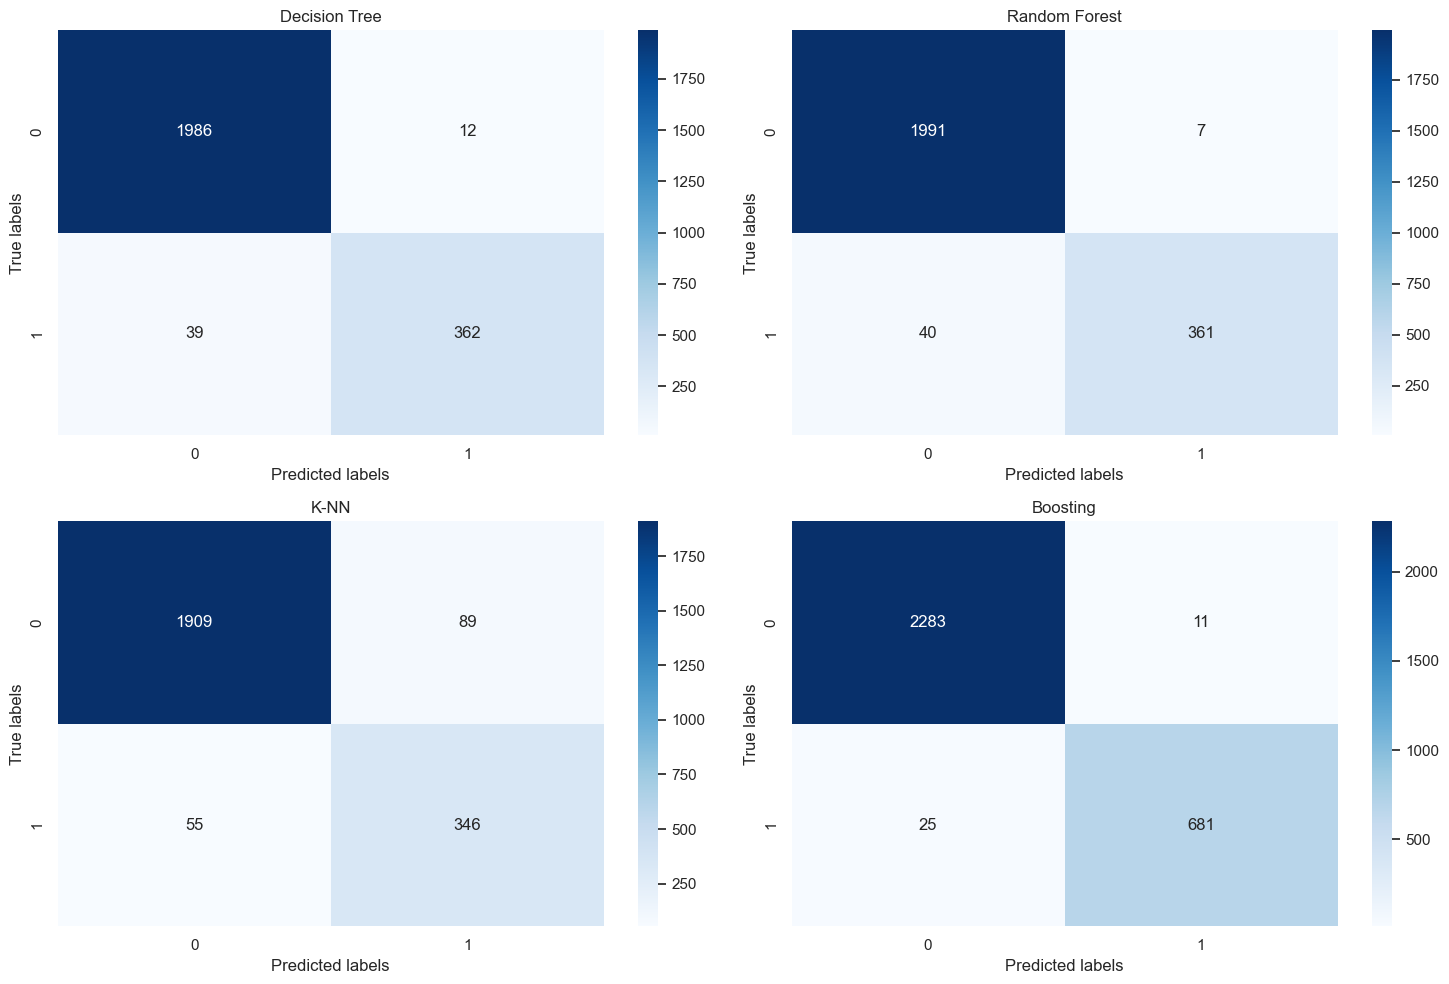

In [ ]:
conf_matrix_tree_boost = confusion_matrix(y_test, y_pred_tree_boost)

model_names = ['Decision Tree', 'Random Forest', 'K-NN', "Boosting"]
conf_matrices = [conf_matrix_tree, conf_matrix_RF, conf_matrix_knn, conf_matrix_tree_boost]

# Créer un sous-graphique avec plusieurs axes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Parcourir chaque matrice de confusion et son nom de modèle associé
for ax, conf_matrix, model_name in zip(axes.flatten(), conf_matrices, model_names):
    # Utiliser seaborn pour afficher la matrice de confusion
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_title(model_name)  # Définir le titre du sous-graphique comme le nom du modèle
    ax.set_xlabel('Predicted labels')  # Définir le titre de l'axe x
    ax.set_ylabel('True labels')  # Définir le titre de l'axe y

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

plt.show()

In [ ]:
# Afficher l'importance normalisée des 8 principales variables dans la prise de décision
importances_features = pd.DataFrame({
    'Decision Tree': best_tree.feature_importances_,
    'Random Forest': best_clf_RF.feature_importances_,
    'Boosting': best_tree_boost.feature_importances_
    }, index=x_train.columns)

importances_features = importances_features.sort_values(by='Decision Tree', ascending=False)
display(importances_features)

,Decision Tree,Random Forest,Boosting
Satisfaction,0.531145,0.374077,0.234765
Temps_passe_dans_entreprise,0.149363,0.186261,0.088808
derniere_evaluation,0.146447,0.115147,0.204861
Nombre_de_projets,0.100828,0.181339,0.081060
Nombre_heures_mensuelles_moyenne,0.067094,0.127923,0.265187
Service,0.002973,0.005515,0.083528
niveau_salaire,0.002151,0.005053,0.024305
Accident_du_travail,0.000000,0.003965,0.016002
promotion_5_dernieres_annees,0.000000,0.000719,0.001482


# Importance des variables

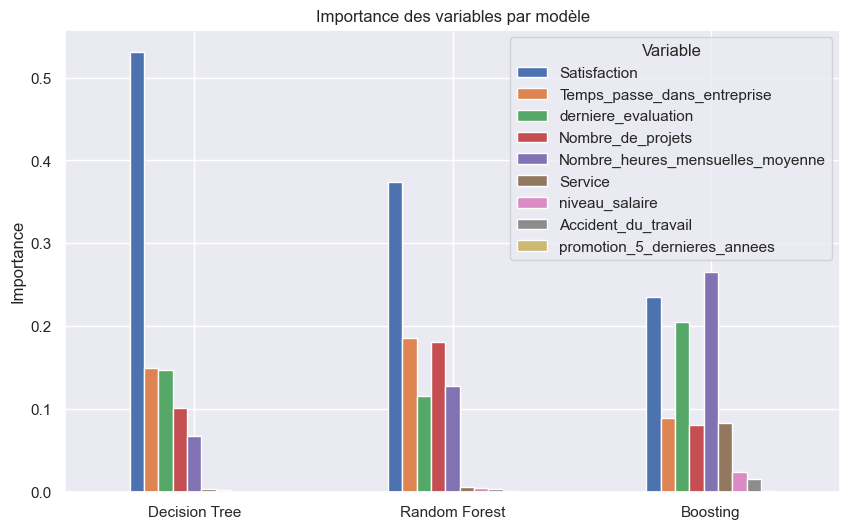

In [ ]:
import matplotlib.pyplot as plt

# Transposer le DataFrame pour avoir les modèles comme index et les variables comme colonnes
importances_transposed = importances_features.transpose()

# Tracer un histogramme groupé
importances_transposed.plot(kind='bar', figsize=(10, 6))
plt.title('Importance des variables par modèle')
plt.ylabel('Importance')
plt.xticks(rotation=0)
plt.legend(title='Variable')
plt.show()